# Food Access Analysis in Washington State: Mapping Low-Income and Low-Access Areas
### Jason Cabusao (jcabusao@uw.edu)

***
## Summary
***

This report presents a comprehensive geospatial analysis of food access in Washington State and aims to identify and visualize areas where residents face challenges in accessing affordable, nutritious food.

Key components of our analysis include:

1. Mapping of census tracts and counties to visualize population distribution across the state.

2. Identification of low-income and low-access areas at both county and census tract levels.

3. Creation of interactive maps to facilitate exploration of food access issues.

4. A brief case study demonstrating the potential application of our findings for strategic intervention.

Our analysis reveals significant disparities in food access across Washington State, with notable differences between urban and rural areas. We found that low-income neighborhoods often correlate with areas of low food access, highlighting the interconnected nature of economic and food security challenges.

This report provides valuable insights for policymakers, community organizations, and businesses seeking to improve food access. By leveraging geospatial data and visualization techniques, we offer a foundation for evidence-based decision-making and targeted interventions to enhance food security across Washington State. The findings presented here underscore the importance of continued monitoring and analysis of food access issues, as well as the potential for data-driven approaches to address this critical aspect of public health and community well-being.

***
## Motivation, Data Setting, and Method
***

In response to the 2008 U.S. Farm Bill, the U.S. Department of Agriculture's [Economic Research Service](https://www.ers.usda.gov/about-ers/) compiled a [June 2009 report to Congress](https://www.ers.usda.gov/publications/pub-details/?pubid=42729):

> According to data from the latest census (2000), about 23.5 million people, or 8.4 percent of the U.S. population, live in low-income neighborhoods that are more than a mile from a supermarket. Low-income neighborhoods are areas where more than 40 percent of the population has income less than or equal to 200 percent of the Federal poverty threshold ($44,000 per year for a family of four in 2008).

In this assessment, I will simulate their analysis by creating geospatial maps to help us understand food access in Washington. There are three geographic region types that I'll use in this assessment:

- **Census tract** is a geographic region used in the U.S. census. It is the smallest of the three region types.
- **County** is a geographic region used for administrative purposes that can include one or more census tracts.
- **State** is a geographic region such as the State of Washington. It is the largest of the three region types.

A census tract is defined as **low access** if enough people in the tract do not have nearby access to grocery stores offering affordable and nutritious food. In urban areas, "low access" is defined as 0.5 miles; in rural areas, "low access" is defined as 10 miles.

`tl_2010_53_tract00.shp` contains the 2010 US census dataset in geospatial shapefile format only for Washington state (53). The only columns you need to use are `CTIDFP00`, the census tract identifier, and `geometry`, the geometric shape of the tract.

`food_access.csv` contains the food access dataset in tabular CSV format. Each row in the dataset corresponds to a census tract for every state in the country (not just Washington). This dataset has many columns:

- `CensusTract` is the census tract identifier.
- `State` is the state name for the census tract.
- `County` is the county name for the census tract.
- `Urban` is a flag (0 or 1) that indicates if this census tract is an urban environment.
- `Rural` is a flag that indicates if this census tract is a rural environment.
- `LATracts_half` is a flag that indicates if this census tract is "low access" in a half mile radius.
- `LATracts10` is a flag that indicates if this census tract is "low access" in a 10 mile radius.
- `LowIncomeTracts` is a flag that indicates if this census tract is "low income".
- `POP2010` is the number of people in this census tract according to the 2010 census.
- `lapophalf` is the number of people in this census tract considered having "low access" in a half mile radius.
- `lapop10` is the number of people in this census tract considered having "low access" in a 10 mile radius.
- `lalowihalf` is similar to `lapophalf` but only counts people considered low access and low income.
- `lalowi10` is similar to `lapop10` but only counts people considered low access and low income.

***
## Results and Code
***

The following packages were installed and imported:

In [1]:
!pip install -q folium mapclassify

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# For testing purposes
import json
import numpy as np
from geopandas.plotting import _plot_polygon_collection
from matplotlib.collections import PatchCollection

with open("expected_idx.json") as f:
    rural_idx, rural_la_idx, urban_ha_idx, lalowi_idx = json.load(f)

class MockAxes:
    def add_collection(self, *args, **kwargs):
        pass

    def autoscale_view(self, *args, **kwargs):
        pass

def assert_patches_allclose(actual_patches, ax=MockAxes(), num_colors=None, **kwargs):
    if isinstance(kwargs.get("geoms"), str):
        kwargs["geoms"] = gpd.read_file(kwargs["geoms"]).geometry
    expected_patches = _plot_polygon_collection(ax=ax, **kwargs)
    for expected, actual in zip(expected_patches.get_paths(), actual_patches.get_paths()):
        try:
            np.testing.assert_allclose(expected.vertices, actual.vertices)
        except AssertionError as e:
            e.args = "wrong selection",
            raise e
    if "color" in kwargs:
        try:
            np.testing.assert_allclose(expected_patches.get_fc(), actual_patches.get_fc())
        except AssertionError as e:
            e.args = "wrong color",
            raise e
    elif isinstance(num_colors, int):
        num_unique = len(np.unique(actual_patches.get_fc(), axis=0))
        assert num_unique == num_colors, f"expected {num_colors} colors, got {num_unique} colors"

### Loading and Merging Datasets

We begin by combining census tract data with food access information. This step is crucial for creating a comprehensive dataset that links geographic information with food access metrics. I wrote a function `load_data` that returns the `GeoDataFrame` resulting from merging the two datasets on the census tract identifiers.

In [3]:
def load_data(shp_path, csv_path):
    """
    Takes in a path to the census tract shapefile and a path to the food access CSV file.
    Merges the two datasets and returns a single GeoDataFrame
    """
    geo_data = gpd.read_file(shp_path)
    csv_data = pd.read_csv(csv_path)

    merged_data = geo_data.merge(csv_data, left_on="CTIDFP00", right_on="CensusTract", how="left")
    return merged_data


state_data = load_data("tl_2010_53_tract00.shp", "food_access.csv")
display(state_data)
print(len(state_data))
assert type(state_data) == gpd.GeoDataFrame
assert list(state_data.columns) == [
    "STATEFP00", "COUNTYFP00", "TRACTCE00", "CTIDFP00", "NAME00", "NAMELSAD00", "MTFCC00",
    "FUNCSTAT00", "ALAND00", "AWATER00", "INTPTLAT00", "INTPTLON00", "geometry", "CensusTract",
    "State", "County", "Urban", "Rural", "LATracts_half", "LATracts10", "GroupQuartersFlag",
    "OHU2010", "NUMGQTRS", "PCTGQTRS", "LowIncomeTracts", "POP2010", "lapophalf", "lalowihalf",
    "lapop10", "lalowi10",
]
assert len(state_data) == 1318

STATEFP00 COUNTYFP00 TRACTCE00     CTIDFP00  NAME00           NAMELSAD00  \
0           53        077    001400  53077001400      14      Census Tract 14   
1           53        077    001600  53077001600      16      Census Tract 16   
2           53        077    000700  53077000700       7       Census Tract 7   
3           53        077    002400  53077002400      24      Census Tract 24   
4           53        077    002200  53077002200      22      Census Tract 22   
...        ...        ...       ...          ...     ...                  ...   
1313        53        063    010202  53063010202  102.02  Census Tract 102.02   
1314        53        063    010301  53063010301  103.01  Census Tract 103.01   
1315        53        063    010504  53063010504  105.04  Census Tract 105.04   
1316        53        063    010303  53063010303  103.03  Census Tract 103.03   
1317        53        063    001600  53063001600      16      Census Tract 16   

     MTFCC00 FUNCSTAT00    ALAND00  AWATER00  ... GroupQuartersFlag OHU2010  \
0      G5020          S    5539748         0  ...               0.0  1203.0   
1      G5020          S   97657363   1509774  ...               NaN     NaN   
2      G5020          S    2930010         0  ...               0.0  2602.0   
3      G5020          S  232557960     69748  ...               NaN     NaN   
4      G5020          S  207645882         0  ...               0.0  2501.0   
...      ...        ...        ...       ...  ...               ...     ...   
1313   G5020          S  184070644         0  ...               0.0  2346.0   
1314   G5020          S   21667422         0  ...               0.0  1612.0   
1315   G5020          S    9371197         0  ...               0.0  1325.0   
1316   G5020          S  107033392         0  ...               0.0  1085.0   
1317   G5020          S    2104249         0  ...               0.0  1430.0   

     NUMGQTRS  PCTGQTRS LowIncomeTracts POP2010    lapophalf   lalowihalf  \
0        62.0  0.018002             1.0  3444.0  2883.838461  1594.727661   
1         NaN       NaN             NaN     NaN          NaN          NaN   
2       141.0  0.019938             1.0  7072.0  1881.362199   948.972610   
3         NaN       NaN             NaN     NaN          NaN          NaN   
4        23.0  0.002970             1.0  7745.0  6137.595205  2770.949604   
...       ...       ...             ...     ...          ...          ...   
1313      8.0  0.001146             0.0  6983.0  6842.568092   860.247108   
1314     13.0  0.003047             1.0  4266.0  3597.752448  1770.888294   
1315      0.0  0.000000             0.0  3546.0  3237.127237   517.875884   
1316     12.0  0.003971             0.0  3022.0  3022.000003   507.539103   
1317      0.0  0.000000             1.0  3738.0   145.702168    99.504575   

         lapop10   lalowi10  
0       0.000000   0.000000  
1            NaN        NaN  
2       0.000000   0.000000  
3            NaN        NaN  
4       0.000000   0.000000  
...          ...        ...  
1313  112.663119  15.763564  
1314    0.000000   0.000000  
1315    0.000000   0.000000  
1316    0.000000   0.000000  
1317    0.000000   0.000000  

[1318 rows x 30 columns]

1318


### Mapping Census Tracts

To understand the granularity of our data, I created a map showing all census tracts in Washington. This provides a foundation for our more detailed analyses.
I wrote a function `plot_census_map` that takes the merged data and returns the `Axes` that contains shapes of all the census tracts in Washington.

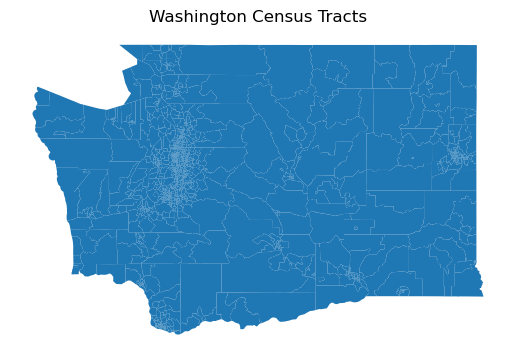

In [4]:
def plot_census_map(state_data):
    """
    Takes in a GeoDataFrame containing spatial data for census tracts and plots 
    a map of census tracts for Washington.
    Returns the Axes that contains shapes of all the census tracts in Washington
    """
    WA_plot = state_data.plot()
    WA_plot.set_axis_off()
    WA_plot.set(title="Washington Census Tracts")
    return WA_plot

ax = plot_census_map(state_data)
layers = ax.findobj(PatchCollection)
assert_patches_allclose(layers[0], geoms=state_data.geometry)
assert len(layers) == 1, "unexpected extra plot layers"
assert ax.get_title() == "Washington Census Tracts", "title does not match expected"
assert not ax.axison, "borders and labels must be hidden"

geometry
0  POLYGON ((-122.88260 46.05175, -122.88261 46.0...

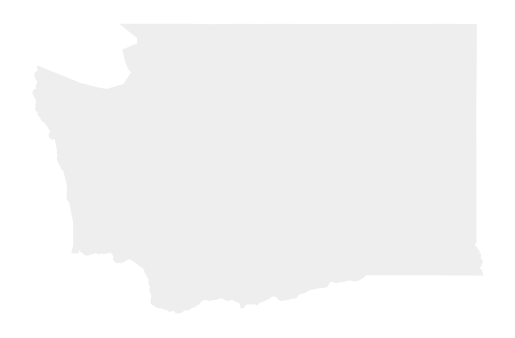

In [5]:
entire_state = state_data[["geometry"]].dissolve()
display(entire_state)
ax = entire_state.plot(color="#EEE")
ax.set_axis_off()

### Population Distribution Across Census Tracts

Next, I visualized the population distribution at the census tract level. This map highlights areas of high and low population density, which is crucial for understanding the potential impact of food access issues.

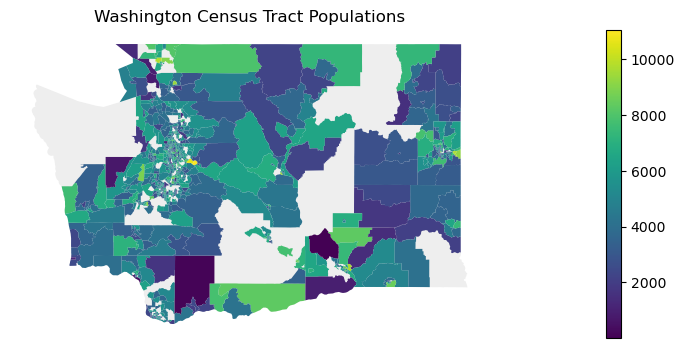

In [6]:
def plot_census_population_map(state_data):
    """
    Takes in a GeoDataFrame containing spatial data and population data for 
    census tracts and returns axes of a map of census tract populations for
    Washington.
    """
    fig, ax = plt.subplots(figsize=(30, 4))

    # Initializing Grey Washington Background 
    entire_state = state_data[["geometry"]].dissolve()
    entire_state.plot(ax=ax, color="#EEE")

    # Plotting census tract populations
    census = state_data.plot(ax=ax, column="POP2010", legend=True)
    census.set(title="Washington Census Tract Populations")

    ax.set_axis_off()

    return ax


ax = plot_census_population_map(state_data)
layers = ax.findobj(PatchCollection)
assert_patches_allclose(layers[0], geoms=entire_state.geometry, color="#EEE")
assert_patches_allclose(layers[1], geoms=state_data.dropna().geometry, num_colors=183)
assert len(layers) == 2, "unexpected extra plot layers"
assert ax.get_title() == "Washington Census Tract Populations", "title does not match expected"
assert not ax.axison, "borders and labels must be hidden"
cbar = ax.get_figure().get_axes()[-1]
assert cbar.get_label() == "<colorbar>", "missing legend"
assert ax.bbox.height == cbar.bbox.height, "map can be enlarged"

### County-Level Population Analysis

To gain a broader perspective, I aggregated our data to the county level. This visualization helps us identify larger regional trends in population distribution across Washington.

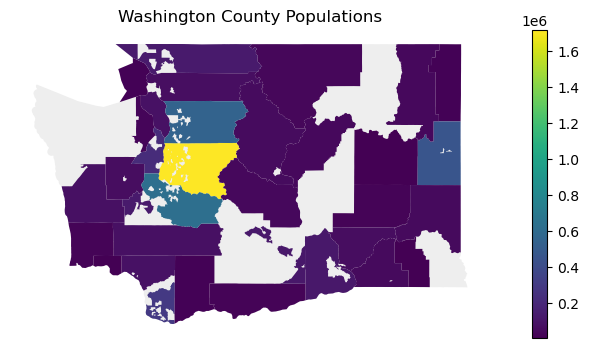

In [7]:
def plot_county_population_map(state_data):
    """
    Takes in a GeoDataFrame containing spatial data and population data 
    for census tracts, merged from the census and food access datasets.
    Returns a map of county populations for Washington.
    """
    fig, ax = plt.subplots(figsize=(11, 4))

    # Initializing Grey Washington Background 
    entire_state = state_data[["geometry"]].dissolve()
    entire_state.plot(ax=ax, color="#EEE")

    county = state_data.dissolve(by="County", aggfunc="sum").plot(ax=ax, column="POP2010", legend=True)
    county.set(title="Washington County Populations")

    ax.set_axis_off()

    return ax


ax = plot_county_population_map(state_data)
layers = ax.findobj(PatchCollection)
assert_patches_allclose(layers[0], geoms=entire_state.geometry, color="#EEE")
assert_patches_allclose(layers[1], geoms="counties.geojson", num_colors=20)
assert len(layers) == 2, "unexpected extra plot layers"
assert ax.get_title() == "Washington County Populations", "title does not match expected"
assert not ax.axison, "borders and labels must be hidden"
cbar = ax.get_figure().get_axes()[-1]
assert cbar.get_label() == "<colorbar>", "missing legend"
assert ax.bbox.height == cbar.bbox.height, "map can be enlarged"

### County-Level Food Access Analysis

To better understand the distribution of food access issues across Washington, I created a series of choropleth maps at the county level. These maps visualize:

- The proportion of people with low access to food within a half-mile radius
- The proportion of low-income people with low access to food within a half-mile radius
- The proportion of people with low access to food within a 10-mile radius
- The proportion of low-income people with low access to food within a 10-mile radius

This multi-faceted view helps us identify areas where food access is particularly challenging, considering both urban and rural contexts.

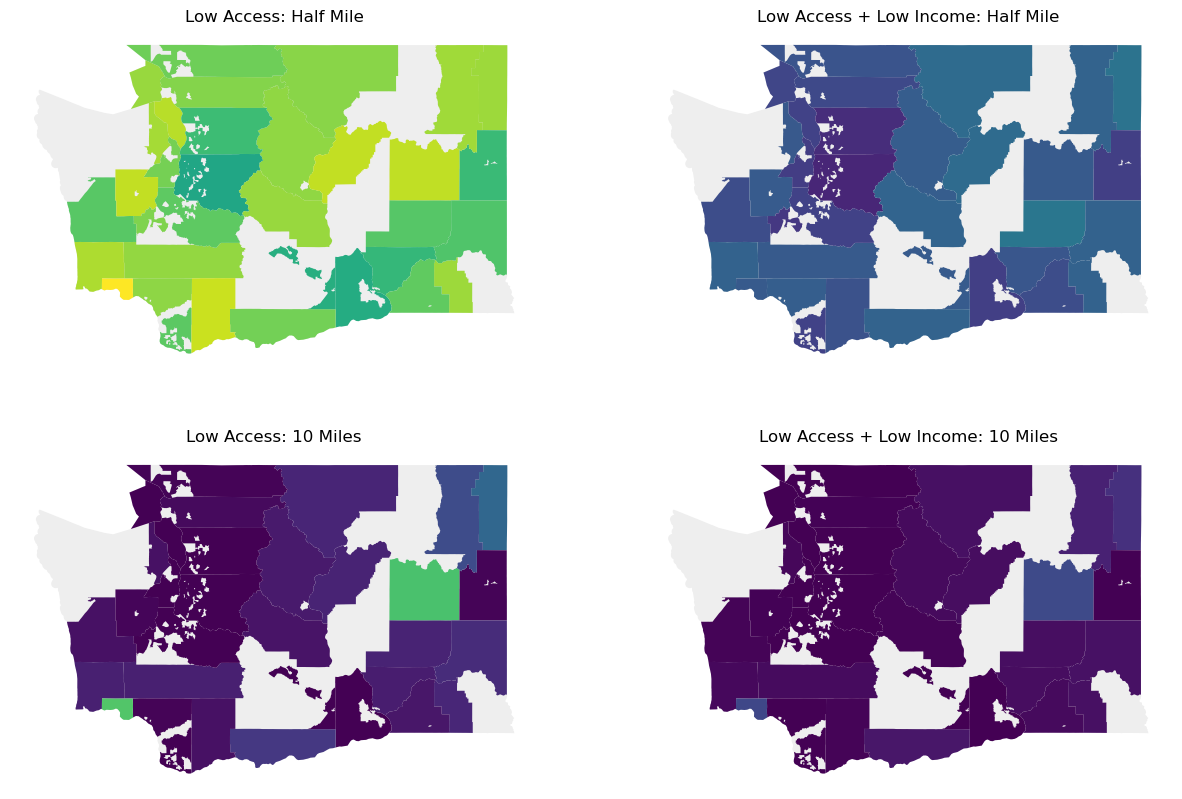

In [8]:
def plot_food_access_by_county_map(state_data):
    """
    Takes in a GeoDataFrame containing spatial data and population data 
    for census tracts, merged from the census and food access datasets.
    Returns 4  maps showing different food access measures for counties in Washington.
    """
    accesses = ["lapophalf", "lalowihalf", "lapop10", "lalowi10"]
    titles = ["Low Access: Half Mile",
              "Low Access + Low Income: Half Mile",
              "Low Access: 10 Miles",
              "Low Access + Low Income: 10 Miles"
             ]
    fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(15, 10))
    axs = [ax1, ax2, ax3, ax4] 

    for access, ax, title in zip(accesses, axs, titles):
        entire_state = state_data[["geometry"]].dissolve()
        entire_state.plot(ax=ax, color="#EEE")
        
        low_access = state_data.dissolve(by="County", aggfunc="sum")[['geometry', 'POP2010',
                                                                          'lapophalf', 'lalowihalf',
                                                                          'lapop10', 'lalowi10']]

        low_access[access] = low_access[access] / low_access["POP2010"]
        
        low_access.plot(ax=ax, column=access, vmin=0, vmax=1)
        ax.set(title=title)
        ax.set_axis_off()

    return axs


axs = plot_food_access_by_county_map(state_data)
expected_titles = ["Low Access: Half Mile", "Low Access + Low Income: Half Mile",
                   "Low Access: 10 Miles", "Low Access + Low Income: 10 Miles"]
for ax, expected_num_colors, expected_title in zip(axs, [31, 23, 19, 16], expected_titles):
    layers = ax.findobj(PatchCollection)
    assert_patches_allclose(layers[0], geoms=entire_state.geometry, color="#EEE")
    assert_patches_allclose(layers[1], geoms="counties.geojson", num_colors=expected_num_colors)
    assert len(layers) == 2, "unexpected extra plot layers"
    assert ax.get_title() == expected_title, f"title {ax.get_title()} does not match expected"
    assert not ax.axison, "borders and labels must be hidden"

#### Limitations of this visualization

While `plot_food_access_by_county_map` is a comprehensive overview of food access measures across counties, its effectiveness as a visualization tool is limited. The lack of a legend makes it difficult to interpret the color scales accurately. Also, presenting separate maps for each measure makes it difficult to analyze the characteristics of a single county. A more effective approach could be to combine all food access variables into a single map, potentially by averaging the measures for each county, and incorporating a clear legend. This consolidated representation would allow users to grasp the overall food access situation of a county at a glance, enhancing the interpretability and usability of the visualization.

### Identifying Low Access Census Tracts
Next, I zoomed in to the census tract level to pinpoint specific areas with low food access. I created a detailed map highlighting:

- Urban census tracts where at least 500 people or 33% of the population have low access within a half-mile
- Rural census tracts where at least 500 people or 33% of the population have low access within 10 miles

This granular view will reveal localized food access challenges that might be obscured at the county level.

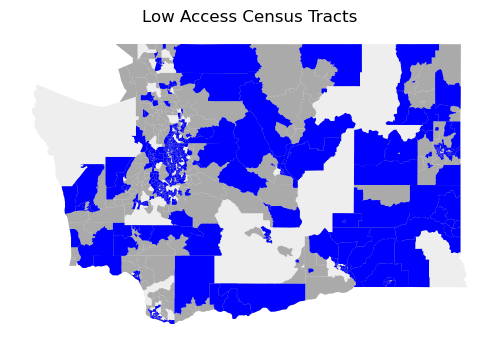

In [9]:
def plot_census_low_access_map(state_data):
    """
    Takes in a GeoDataFrame containing spatial data, population data, and food access data.
    Returns a map of census tracts in Washington, highlighting low access tracts in urban and rural areas.
    """
    fig, ax = plt.subplots(figsize=(11, 4))

    # Plotting the map of Washington 
    entire_state = state_data[["geometry"]].dissolve()
    entire_state.plot(ax=ax, color="#EEE")

    # Plotting urban census tracks
    urban = state_data[state_data['Urban'] == 1.0]
    urban.plot(ax=ax, legend=True, color='#AAA')

    # Plotting rural census tracks
    rural = state_data[state_data['Rural'] == 1.0]
    rural.plot(ax=ax, legend=True, color='#AAA')

    # Plotting low acess urban census tracks
    la_urban = urban[(urban['lapophalf'] > 500) | ((urban['lapophalf'] / urban['POP2010']) > 0.33)]
    la_urban.plot(ax=ax, color='blue')

    # Plotting low acess rural census tracks
    la_rural = rural[(rural['lapop10'] > 500) | ((rural['lapop10'] / rural['POP2010']) > 0.33)]
    la_rural.plot(ax=ax, color='blue')

    ax.set(title='Low Access Census Tracts')
    ax.set_axis_off()
    
    return ax


ax = plot_census_low_access_map(state_data)
layers = ax.findobj(PatchCollection)
assert_patches_allclose(layers[0], geoms=entire_state.geometry, color="#EEE")
urban_idx = state_data["Urban"].notna() & ~state_data.index.isin(rural_idx)
urban_la_idx = urban_idx & ~state_data.index.isin(urban_ha_idx)
error = None
for i, j, k, l in [
    [1, 2, 3, 4], # urban, rural, urban low access, rural low access
    [2, 1, 3, 4], # rural, urban, urban low access, rural low access
    [1, 2, 4, 3], # urban, rural, rural low access, urban low access
    [2, 1, 4, 3], # rural, urban, rural low access, urban low access
    [1, 3, 2, 4], # urban, urban low access, rural, rural low access
    [3, 1, 4, 2], # rural, rural low access, urban, urban low access
]:
    try:
        assert_patches_allclose(layers[i], geoms=state_data.loc[urban_idx, "geometry"], color="#AAA")
        assert_patches_allclose(layers[j], geoms=state_data.loc[rural_idx, "geometry"], color="#AAA")
        assert_patches_allclose(layers[k], geoms=state_data.loc[urban_la_idx, "geometry"])
        assert_patches_allclose(layers[l], geoms=state_data.loc[rural_la_idx, "geometry"])
        break
    except AssertionError as e:
        if error is None: # Store only the first error encountered during testing
            error = e
else: # Only raise an error if none of the possible ways to layer the plot worked
    raise error
assert len(layers) == 5, "unexpected extra plot layers"
assert ax.get_title() == "Low Access Census Tracts", "title does not match expected"
assert not ax.axison, "borders and labels must be hidden"

#### Leveraging Food Access Visualization Tools to Inform Government Policy and Organizational Strategy

Government or food access organizations could use these plots to identify areas with low food access and prioritizing them for interventions or resource allocation. These plots provide a visual representation of the spatial distribution of food access challenges, allowing decision-makers to pinpoint specific counties or census tracts that require immediate attention. However, a potential limitation of this is the accuracy and completeness of the underlying data used to generate the plots. If the data is outdated, incomplete, or contains errors, the plots may not accurately reflect the current state of food access in the area. Additionally, introducing new grocery stores or improving access in certain areas could lead to displacement of existing residents if it results in increased property values or rents.

### Interactive Exploration of Food Access

To provide a more dynamic and user-friendly way to explore our findings, I created an interactive map inspired by the USDA's Food Access Research Atlas. This map will focus on low-income census tracts with significant low access to food, allowing users to:

- Visualize low-income and low-access areas across Washington State
- Distinguish between urban (half-mile threshold) and rural (10-mile threshold) low access areas
- Explore specific regions in detail through zooming and panning capabilities

In [10]:
def interactive_map(state_data):
    """
    Takes in a a GeoDataFrame containing census tract data and creates an interactive
    map using Folium for low-income and low-access census tracts in Washington.
    Returns an interactive map object displaying the relevant low-income and
    low-access census tracts in Washington.
    """
    low_inc = state_data[state_data['LowIncomeTracts'] == 1.0][['geometry','LowIncomeTracts',
                                                                'LATracts_half', 'LATracts10',
                                                                'Urban', 'Rural']]

    lila_both = low_inc[(
        (low_inc['LATracts_half'] == 1.0) & (low_inc['Urban'] == 1.0)
    ) | (
        (low_inc['LATracts10'] == 1.0) & (low_inc['Rural'] == 1.0)
    )]

    return lila_both.explore()


map = interactive_map(state_data)
display(map)
last_child = next(reversed(map._children.values()))
from folium.features import GeoJson
assert type(last_child) == GeoJson, "last child should be GeoJson; do not specify column"
geojson = last_child.data
assert set(int(d["id"]) for d in geojson["features"]) == set(lalowi_idx), "wrong selection"

The following cell plots a preview of your interactive map for the PDF printout.

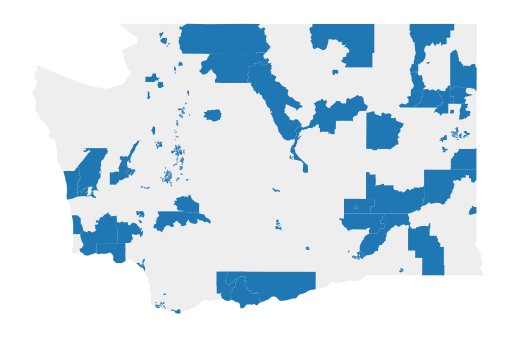

In [11]:
ax = entire_state.plot(color="#EEE")
gpd.GeoDataFrame.from_features(geojson, crs="EPSG:4326").plot(ax=ax)
ax.set_axis_off()

#### Strategic Supermarket Placement: A Case Study in Improving Food Access

Using our interactive food access map, we identified a low-income, low-access census tract in Vancouver, WA as a prime candidate for intervention. We propose the addition of a new supermarket near the intersection of NE 121st Ave and NE 56th St. This location was chosen for its central position within the census tract, ensuring that all residents would be within a 0.5-mile radius of the new store. This strategic placement would effectively eliminate the "low access" designation for the entire area, significantly improving food access for all residents.

Key considerations in this decision included maximizing community impact, leveraging existing infrastructure, and creating a model for future interventions in similar low-access areas. By addressing the food access needs of this entire census tract, we aim to improve the quality of life and health outcomes for a substantial number of low-income residents, while potentially stimulating local economic activity.

This case study demonstrates how our food access mapping tools can be applied to make data-driven decisions that have tangible impacts on community well-being.

***
## Conclusion: Mapping the Path to Improved Food Access in Washington State
***

Our comprehensive analysis of food access in Washington State has revealed several key insights. We identified significant variations in food access across different counties and census tracts, highlighting the need for targeted interventions. Our maps illustrated distinct challenges faced by urban and rural areas, with different distance thresholds for defining low access in these settings. The overlap between low-income areas and low food access areas underscores the complex relationship between economic factors and food security.

Our census tract-level analysis pinpointed specific neighborhoods facing acute food access issues, providing valuable information for community-level interventions. The development of an interactive map tool demonstrates the potential for dynamic, user-friendly interfaces to aid in decision-making and public awareness. Our case study on supermarket placement illustrates how data-driven approaches can guide practical solutions to food access problems.

These findings emphasize the importance of nuanced, geospatially-informed strategies in addressing food access issues. By leveraging this data, policymakers, community organizations, and businesses can work together to develop targeted solutions that improve food access across Washington State.

Moving forward, regular updates to this analysis will be crucial to track progress and identify emerging trends in food access. Additionally, integrating this data with other socioeconomic and health indicators could provide an even more comprehensive understanding of food security challenges in the state. Ultimately, this project serves as a foundation for evidence-based decision-making, aiming to ensure that all Washington residents have access to affordable, nutritious food – a key component of community health and well-being.